### 1 Setup
#### 1.1 Library and duckdb file import

In [1]:
# EXPLORING DATA

import duckdb, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import textwrap

# cria ou liga se já existir:
con = duckdb.connect("movielens100K.duckdb")

#### 1.2 Tables from the original dataset
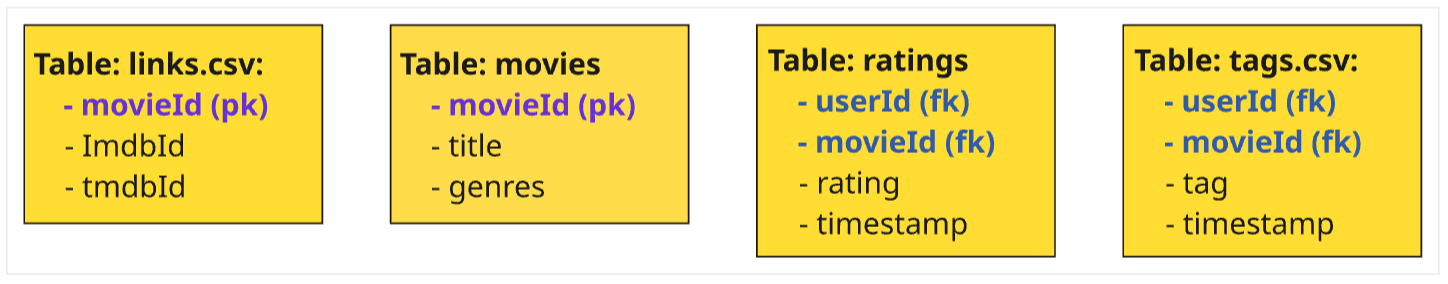

### 2 Research Questions
#### 2.1 The 20 movies with the highest rating (with at least 50 ratings)

In [2]:
# Find the 20 movies with the highest rating (with at least 50 ratings)
df1 = con.sql("""
SELECT
    m.title,
    ROUND(AVG(r.rating), 2) AS media_rating,
    COUNT(*)                AS total_ratings
FROM ratings r
JOIN movies m USING (movieId)
GROUP BY m.title
HAVING COUNT(*) > 50
ORDER BY media_rating DESC, total_ratings DESC
LIMIT 20
""").df()

df1


,title,media_rating,total_ratings
0,"Shawshank Redemption, The (1994)",4.43,317
1,"Godfather, The (1972)",4.29,192
2,Fight Club (1999),4.27,218
3,Dr. Strangelove or: How I Learned to Stop Worr...,4.27,97
4,Cool Hand Luke (1967),4.27,57
5,"Godfather: Part II, The (1974)",4.26,129
6,Rear Window (1954),4.26,84
7,Goodfellas (1990),4.25,126
8,"Departed, The (2006)",4.25,107
9,"Usual Suspects, The (1995)",4.24,204


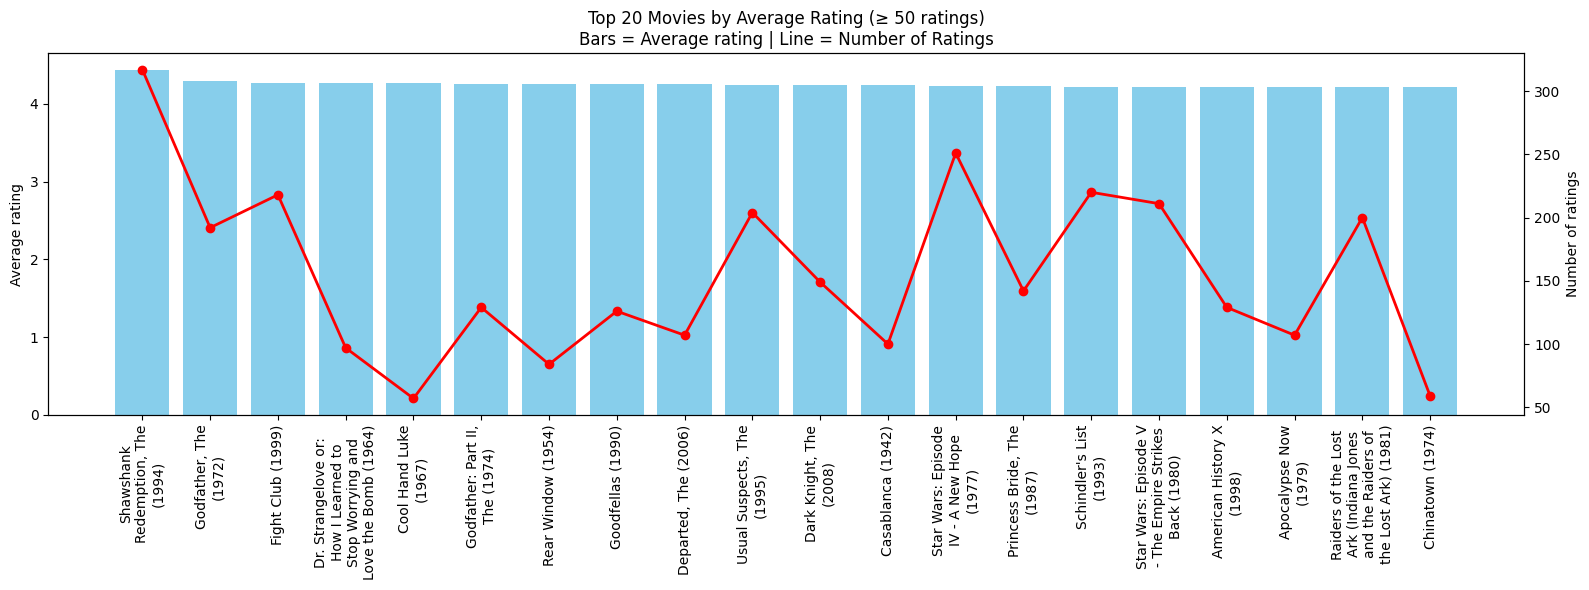

In [3]:
# Combined plot: bars = average rating, line = number of ratings
fig, ax1 = plt.subplots(figsize=(16, 6))

wrapped_titles = [ "\n".join(textwrap.wrap(t, 20)) for t in df1["title"] ]

ax1.bar(df1["title"], df1["media_rating"], color="skyblue")
ax1.set_ylabel("Average rating")
ax1.set_xticks(range(len(df1)))
ax1.set_xticklabels(wrapped_titles, rotation=90, ha="center")

# Line plot
ax2 = ax1.twinx()
ax2.plot(range(len(df1)), df1["total_ratings"], marker="o", color="red", linewidth=2)
ax2.set_ylabel("Number of ratings")

plt.title("Top 20 Movies by Average Rating (≥ 50 ratings)\nBars = Average rating | Line = Number of Ratings")
plt.tight_layout()
plt.show()


#### 2.2 Ranking of the 20 movies with the most ratings

In [4]:

# ranking of the 20 movies with the most ratings
df2 = con.sql("""
SELECT
    m.title,
    COUNT(*) AS total_ratings,
    ROUND(AVG(r.rating), 2) AS media_rating
FROM ratings r
JOIN movies m USING (movieId)
GROUP BY m.title
ORDER BY total_ratings DESC, media_rating DESC
LIMIT 20
""").df()

df2




,title,total_ratings,media_rating
0,Forrest Gump (1994),329,4.16
1,"Shawshank Redemption, The (1994)",317,4.43
2,Pulp Fiction (1994),307,4.20
3,"Silence of the Lambs, The (1991)",279,4.16
4,"Matrix, The (1999)",278,4.19
5,Star Wars: Episode IV - A New Hope (1977),251,4.23
6,Jurassic Park (1993),238,3.75
7,Braveheart (1995),237,4.03
8,Terminator 2: Judgment Day (1991),224,3.97
9,Schindler's List (1993),220,4.22


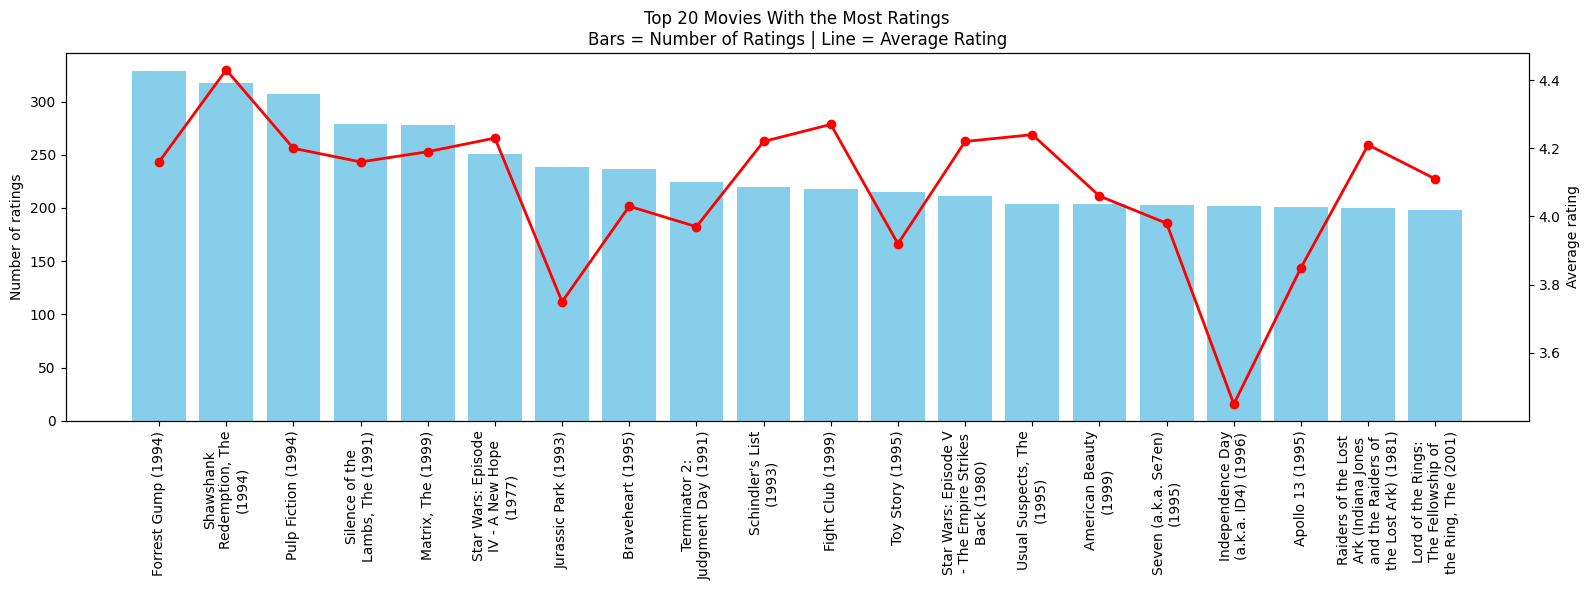

In [5]:
# ranking of the 20 movies with the most ratings
fig, ax1 = plt.subplots(figsize=(16, 6))

# Wrap titles into multiple lines (≈20 chars per line)
wrapped_titles = ["\n".join(textwrap.wrap(t, 20)) for t in df2["title"]]

# Bars = number of ratings (blue)
ax1.bar(df2["title"], df2["total_ratings"], color="skyblue")
ax1.set_ylabel("Number of ratings")
ax1.set_xticks(range(len(df2)))
ax1.set_xticklabels(wrapped_titles, rotation=90, ha="center")  # melhor sem rotação

# Line = average rating (red)
ax2 = ax1.twinx()
ax2.plot(range(len(df2)), df2["media_rating"], marker="o", color="red", linewidth=2)
ax2.set_ylabel("Average rating")

plt.title("Top 20 Movies With the Most Ratings\nBars = Number of Ratings | Line = Average Rating")
plt.tight_layout()
plt.show()


#### 2.3 Best Ranking movie by Genre

In [6]:
# ranking dos filmes por genero (com pelo menos 50 avaliações)
df3 = con.sql("""
WITH genero_filme AS (
    SELECT
        m.movieId,
        m.title,
        unnest(string_split(m.genres, '|')) AS genre
    FROM movies m
),
stats_genero_filme AS (
    SELECT
        gf.genre,
        gf.movieId,
        gf.title,
        COUNT(*) AS total_ratings,
        AVG(r.rating) AS media_rating
    FROM genero_filme gf
    JOIN ratings r
      ON r.movieId = gf.movieId
    GROUP BY gf.genre, gf.movieId, gf.title
    HAVING COUNT(*) >= 50          
),
ranking_por_genero AS (
    SELECT
        genre,
        movieId,
        title,
        total_ratings,
        media_rating,
        ROW_NUMBER() OVER (
            PARTITION BY genre
            ORDER BY media_rating DESC, total_ratings DESC
        ) AS posicao
    FROM stats_genero_filme
)
SELECT
    genre,
    title,
    ROUND(media_rating, 2) AS media_rating,
    total_ratings
FROM ranking_por_genero
WHERE posicao = 1
ORDER BY genre
""").df()

df3

,genre,title,media_rating,total_ratings
0,Action,Fight Club (1999),4.27,218
1,Adventure,"Princess Bride, The (1987)",4.23,142
2,Animation,Spirited Away (Sen to Chihiro no kamikakushi) ...,4.16,87
3,Children,Toy Story 3 (2010),4.11,55
4,Comedy,Dr. Strangelove or: How I Learned to Stop Worr...,4.27,97
5,Crime,"Shawshank Redemption, The (1994)",4.43,317
6,Documentary,Bowling for Columbine (2002),3.78,58
7,Drama,"Shawshank Redemption, The (1994)",4.43,317
8,Fantasy,"Princess Bride, The (1987)",4.23,142
9,Film-Noir,Chinatown (1974),4.21,59


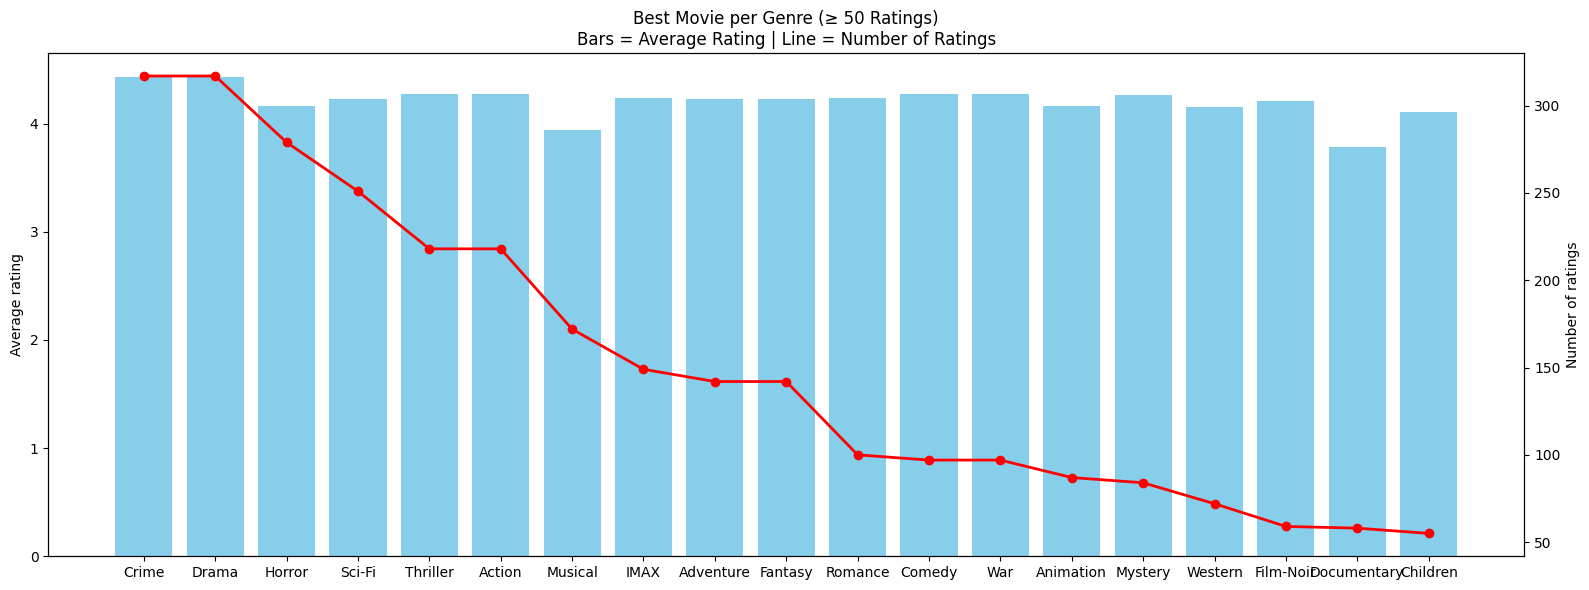

In [7]:
# Sort by number of ratings (descending)
df3_plot = df3.sort_values("total_ratings", ascending=False)

x = np.arange(len(df3_plot))   # 0..N-1

fig, ax1 = plt.subplots(figsize=(16, 6))

# Bars = average rating
ax1.bar(x, df3_plot["media_rating"], color="skyblue")
ax1.set_ylabel("Average rating")

# Line = number of ratings
ax2 = ax1.twinx()
ax2.plot(x, df3_plot["total_ratings"], marker="o", color="red", linewidth=2)
ax2.set_ylabel("Number of ratings")

# Genres as x-axis labels
plt.xticks(x, df3_plot["genre"], rotation=90)

plt.title("Best Movie per Genre (≥ 50 Ratings)\nBars = Average Rating | Line = Number of Ratings")
plt.tight_layout()
plt.show()

#### 2.4 Ranking of the highest-rated movies by genre (with at least 50 ratings)

In [8]:
# ranking of the highest-rated movies by genre (with at least 50 ratings)

con.sql("""
WITH genero_filme AS (
    SELECT
        m.movieId,
        m.title,
        unnest(string_split(m.genres, '|')) AS genre
    FROM movies m
),
stats_genero_filme AS (
    SELECT
        gf.genre,
        gf.movieId,
        gf.title,
        COUNT(*) AS total_ratings,
        AVG(r.rating) AS media_rating
    FROM genero_filme gf
    JOIN ratings r
      ON r.movieId = gf.movieId
    GROUP BY gf.genre, gf.movieId, gf.title
    HAVING COUNT(*) >= 50 
),
ranking_por_genero AS (
    SELECT
        genre,
        movieId,
        title,
        total_ratings,
        media_rating,
        ROW_NUMBER() OVER (
            PARTITION BY genre
            ORDER BY total_ratings DESC, media_rating DESC
        ) AS posicao
    FROM stats_genero_filme
)
SELECT
    genre,
--    posicao,
    title,
    total_ratings,
    ROUND(media_rating, 2) AS media_rating
FROM ranking_por_genero
WHERE posicao <= 1
ORDER BY genre, posicao
""").df()

,genre,title,total_ratings,media_rating
0,Action,"Matrix, The (1999)",278,4.19
1,Adventure,Star Wars: Episode IV - A New Hope (1977),251,4.23
2,Animation,Toy Story (1995),215,3.92
3,Children,Toy Story (1995),215,3.92
4,Comedy,Forrest Gump (1994),329,4.16
5,Crime,"Shawshank Redemption, The (1994)",317,4.43
6,Documentary,Bowling for Columbine (2002),58,3.78
7,Drama,Forrest Gump (1994),329,4.16
8,Fantasy,Toy Story (1995),215,3.92
9,Film-Noir,L.A. Confidential (1997),97,4.06


#### 2.5 Most common tags

In [9]:
# Most common tags

con.sql("""
SELECT
    LOWER(TRIM(word)) AS word,
    COUNT(*) AS total
FROM (
    SELECT unnest(string_split(tag, ' ')) AS word
    FROM tags
)
WHERE word <> ''
  AND LENGTH(word) > 2
  AND word NOT IN ('the', 'and', 'for', 'with', 'this', 'that', 'are')
GROUP BY word
ORDER BY total DESC
LIMIT 30
""").df()

,word,total
0,netflix,134
1,queue,131
2,comedy,60
3,dark,46
4,atmospheric,36
5,ending,29
6,space,27
7,funny,27
8,crime,26
9,superhero,25


#### 2.6 Most repeated tag by movie

In [10]:

# Saber o tag mais repetido por filme:

df_tags=con.sql("""
WITH palavras_por_filme AS (
    SELECT
        t.movieId,
        LOWER(TRIM(word)) AS palavra,
        COUNT(*) AS total
    FROM (
        SELECT movieId, unnest(string_split(tag, ' ')) AS word
        FROM tags
    ) t
    WHERE palavra <> ''
      AND LENGTH(palavra) > 2
      AND palavra NOT IN ('the', 'and', 'for', 'with', 'this', 'that', 'are', 'was')
    GROUP BY t.movieId, palavra
),
ranking_por_filme AS (
    SELECT
        movieId,
        palavra,
        total,
        ROW_NUMBER() OVER (PARTITION BY movieId ORDER BY total DESC) AS posicao
    FROM palavras_por_filme
)
SELECT
    m.movieId,
    m.title,
    r.palavra,
    r.total
FROM ranking_por_filme r
JOIN movies m USING (movieId)
WHERE r.posicao <= 5
ORDER BY r.total DESC
LIMIT 20
""").df()

df_tags

,movieId,title,palavra,total
0,296,Pulp Fiction (1994),violence,6
1,260,Star Wars: Episode IV - A New Hope (1977),sci-fi,6
2,260,Star Wars: Episode IV - A New Hope (1977),space,6
3,750,Dr. Strangelove or: How I Learned to Stop Worr...,comedy,5
4,260,Star Wars: Episode IV - A New Hope (1977),classic,5
5,296,Pulp Fiction (1994),dialogue,5
6,2959,Fight Club (1999),dark,4
7,296,Pulp Fiction (1994),soundtrack,4
8,1200,Aliens (1986),space,4
9,296,Pulp Fiction (1994),tarantino,4


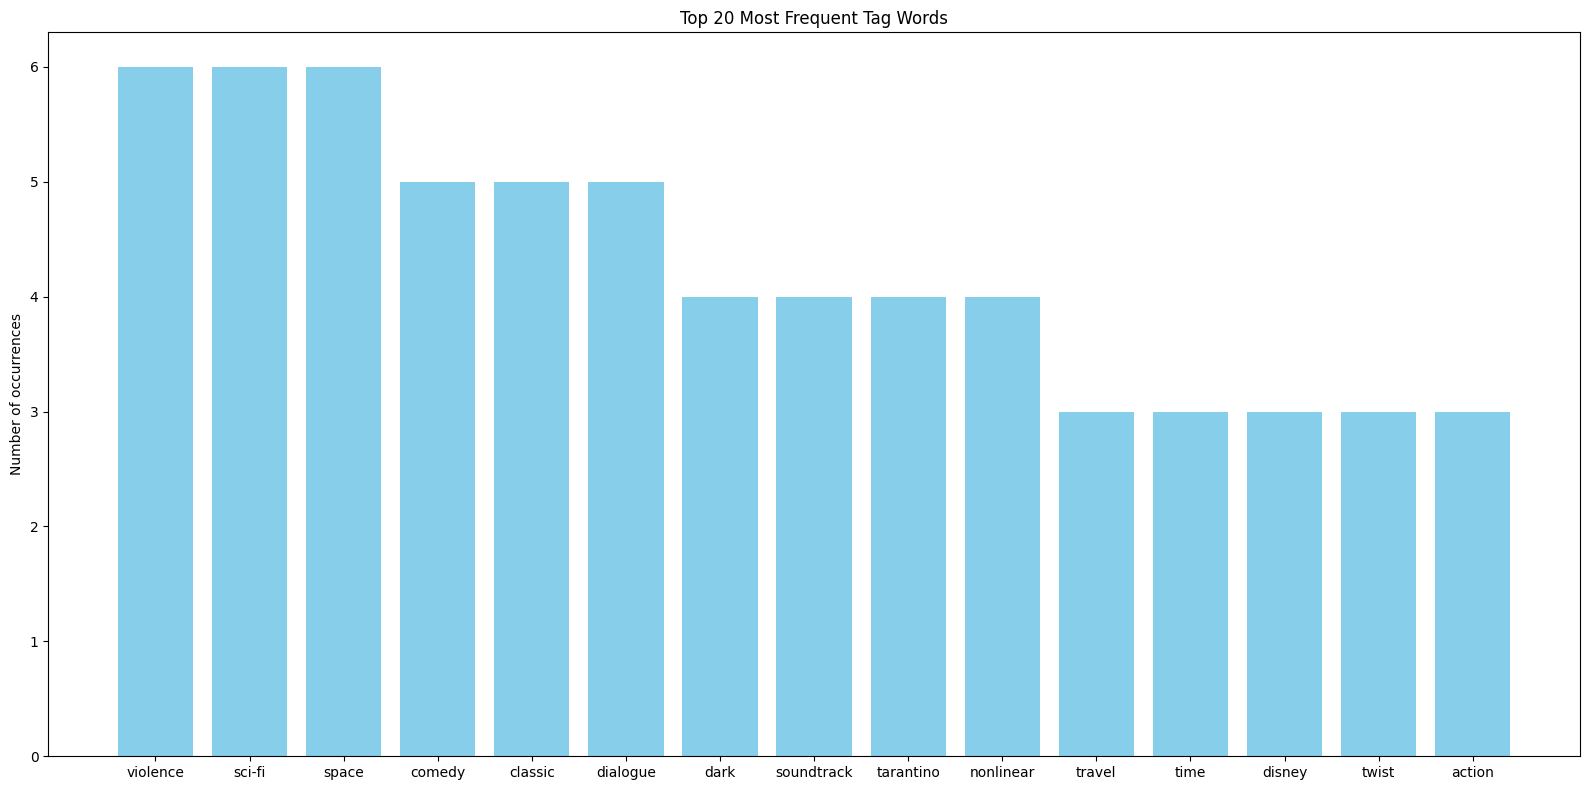

In [11]:
# Top 20 repeated tag by movie
df_top = df_tags.sort_values("total", ascending=False).head(20)

plt.figure(figsize=(16, 8))
plt.bar(df_top["palavra"], df_top["total"], color="skyblue")

plt.title("Top 20 Most Frequent Tag Words")
plt.ylabel("Number of occurrences")
plt.xticks(rotation=0, ha="center")

plt.tight_layout()
plt.show()

#### 2.7 Users with the highest number of ratings and their average score

In [12]:
# Identify the users with the highest number of ratings and their average score

con.sql("""
SELECT
    r.userId,
    COUNT(*) AS total_ratings,
    ROUND(AVG(r.rating), 2) AS media_rating
FROM ratings r
GROUP BY r.userId
ORDER BY total_ratings DESC, media_rating DESC
LIMIT 20
""").df()

,userId,total_ratings,media_rating
0,414,2698,3.39
1,599,2478,2.64
2,474,2108,3.40
3,448,1864,2.85
4,274,1346,3.24
5,610,1302,3.69
6,68,1260,3.23
7,380,1218,3.67
8,606,1115,3.66
9,288,1055,3.15


In [13]:
# Identify the users with the highest number of ratings and their average score

df_users = con.sql("""
SELECT
    userId,
    COUNT(*) AS total_ratings,
    ROUND(AVG(rating), 2) AS media_rating
FROM ratings
GROUP BY userId
""").df()


In [14]:
# Obtain basic statistics about the number of ratings per user
serie = df_users["total_ratings"]

mean_val = serie.mean()
std_val = serie.std()
median_val = serie.median()
mode_val = serie.mode()[0]          
min_val = serie.min()
max_val = serie.max()
desc = serie.describe()

print(
    f"Mean = {mean_val:.2f}\n"
    f"Standard deviation = {std_val:.2f}\n"
    f"Median = {median_val:.2f}\n"
    f"Mode = {mode_val}\n"
    f"Minimum = {min_val}\n"
    f"Maximum = {max_val}\n"
)



Mean = 165.30
Standard deviation = 269.48
Median = 70.50
Mode = 21
Minimum = 20
Maximum = 2698



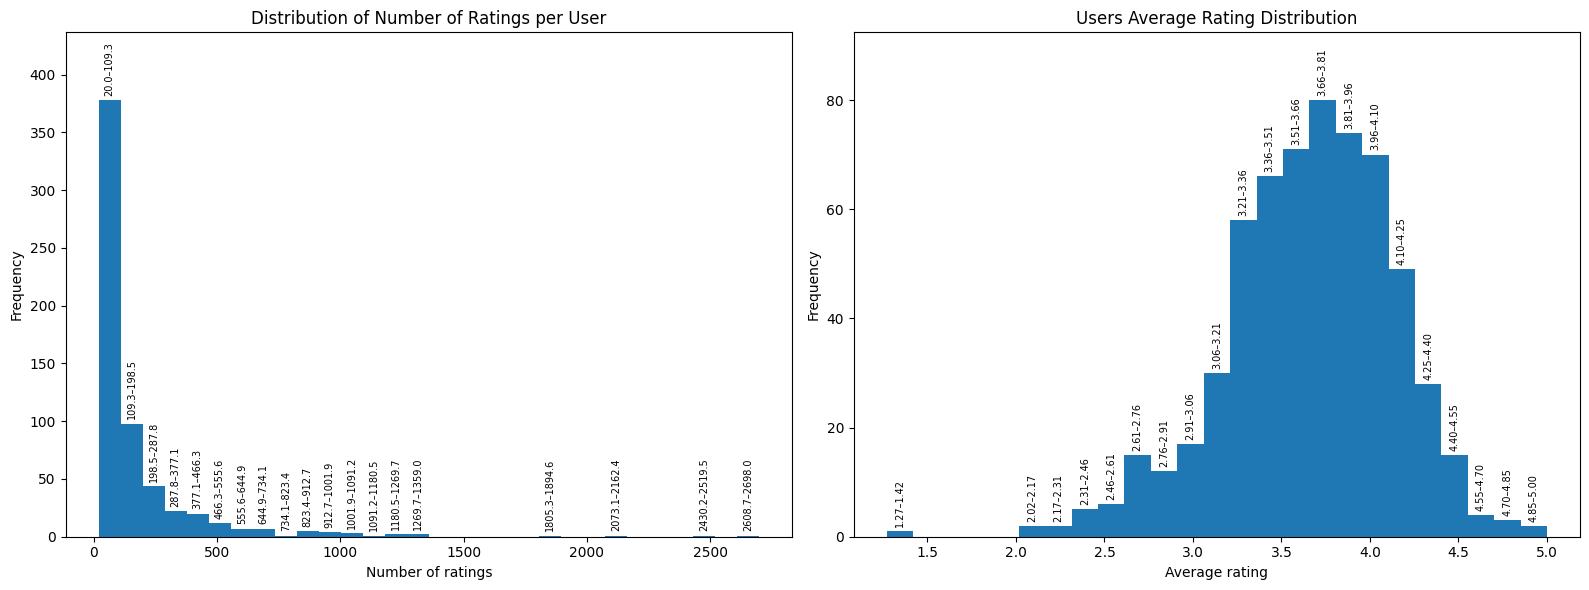

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram: number of ratings per user
counts, bins, patches = axes[0].hist(df_users["total_ratings"], bins=30)
axes[0].set_title("Distribution of Number of Ratings per User")
axes[0].set_xlabel("Number of ratings")
axes[0].set_ylabel("Frequency")



# Add label = interval for each bar
for i, patch in enumerate(patches):
    height = patch.get_height()
    if height > 0:
        interval_label = f"{bins[i]:.1f}–{bins[i+1]:.1f}"
        axes[0].annotate(
            interval_label,
            xy=(patch.get_x() + patch.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=7,
            rotation=90
        )

# Histogram: average rating per user
counts2, bins2, patches2 = axes[1].hist(df_users["media_rating"], bins=25)
axes[1].set_title("Users Average Rating Distribution")
axes[1].set_xlabel("Average rating")
axes[1].set_ylabel("Frequency")

# Add interval labels to second plot
for i, patch in enumerate(patches2):
    height = patch.get_height()
    if height > 0:
        interval_label = f"{bins2[i]:.2f}–{bins2[i+1]:.2f}"
        axes[1].annotate(
            interval_label,
            xy=(patch.get_x() + patch.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=7,
            rotation=90
        )

axes[0].set_ylim(top = axes[0].get_ylim()[1] * 1.1)
axes[1].set_ylim(top = axes[1].get_ylim()[1] * 1.1)

plt.tight_layout()
plt.show()


#### 2.8 Weighted top20 (50% avg rating, 50% scaled nº ratings)

In [16]:
# ...existing code...
# Weighted top20 (50% avg rating, 50% scaled nº ratings) — exclui filmes com poucas avaliações
MIN_RATINGS = 50

df_weighted = con.sql(f"""
WITH movie_stats AS (
    SELECT
        m.movieId,
        m.title,
        AVG(r.rating) AS avg_rating,
        COUNT(*) AS total_ratings
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.movieId, m.title
    HAVING COUNT(*) >= {MIN_RATINGS}          -- filtro para excluir filmes com poucas avaliações
),
with_minmax AS (
    SELECT
        *,
        MIN(total_ratings) OVER () AS min_ratings,
        MAX(total_ratings) OVER () AS max_ratings
    FROM movie_stats
),
scored AS (
    SELECT
        movieId,
        title,
        ROUND(avg_rating, 2) AS avg_rating,
        total_ratings,
        -- escala linear do total_ratings para o intervalo [1,5]
        CASE
            WHEN max_ratings = min_ratings THEN 3.0
            ELSE 1.0 + 4.0 * (total_ratings - min_ratings) / (max_ratings - min_ratings)
        END AS scaled_count_1_5
    FROM with_minmax
)
SELECT
    title,
    avg_rating,
    total_ratings,
    ROUND(scaled_count_1_5, 2) AS scaled_count_1_5,
    ROUND(0.5 * avg_rating + 0.5 * scaled_count_1_5, 2) AS weighted_score
FROM scored
ORDER BY weighted_score DESC, total_ratings DESC
LIMIT 20
""").df()

df_weighted
# ...existing code...

,title,avg_rating,total_ratings,scaled_count_1_5,weighted_score
0,"Shawshank Redemption, The (1994)",4.43,317,4.83,4.63
1,Forrest Gump (1994),4.16,329,5.00,4.58
2,Pulp Fiction (1994),4.20,307,4.68,4.44
3,"Matrix, The (1999)",4.19,278,4.27,4.23
4,"Silence of the Lambs, The (1991)",4.16,279,4.28,4.22
5,Star Wars: Episode IV - A New Hope (1977),4.23,251,3.88,4.06
6,Braveheart (1995),4.03,237,3.68,3.86
7,Fight Club (1999),4.27,218,3.41,3.84
8,Schindler's List (1993),4.22,220,3.44,3.83
9,Star Wars: Episode V - The Empire Strikes Back...,4.22,211,3.31,3.76


#### 2.9 Weighted Movie Scores 
##### 2.9.1 Weighted Movie Scores Grouped by years
Years with at least 100 Films per Year and movies with at least 50 ratings

In [17]:
MIN_RATINGS = 50

df_year = con.sql(f"""
WITH movie_stats AS (
    SELECT
        m.movieId,
        m.title,
        AVG(r.rating) AS avg_rating,
        COUNT(*) AS total_ratings
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.movieId, m.title
    HAVING COUNT(*) >= {MIN_RATINGS}
),
with_minmax AS (
    SELECT
        *,
        MIN(total_ratings) OVER () AS min_ratings,
        MAX(total_ratings) OVER () AS max_ratings
    FROM movie_stats
),
scored_with_year_str AS (
    SELECT
        movieId,
        title,
        ROUND(avg_rating, 2) AS avg_rating,
        total_ratings,
        CASE
            WHEN max_ratings = min_ratings THEN 3.0
            ELSE 1.0 + 4.0 * (total_ratings - min_ratings) / (max_ratings - min_ratings)
        END AS scaled_count_1_5,
        regexp_extract(title, '.*\\((\\d{{4}})\\)$', 1) AS year_str
    FROM with_minmax
),
scored AS (
    SELECT
        movieId,
        title,
        avg_rating,
        total_ratings,
        scaled_count_1_5,
        CAST(year_str AS INTEGER) AS year
    FROM scored_with_year_str
    WHERE year_str IS NOT NULL AND year_str <> ''
)
SELECT
    year,
    AVG(0.5 * avg_rating + 0.5 * scaled_count_1_5) AS avg_weighted_score,
    COUNT(*) AS n_movies
FROM scored
GROUP BY year
HAVING COUNT(*) >= 101        -- só anos com 100+ filmes
ORDER BY year
""").df()

df_year


,year,avg_weighted_score,n_movies


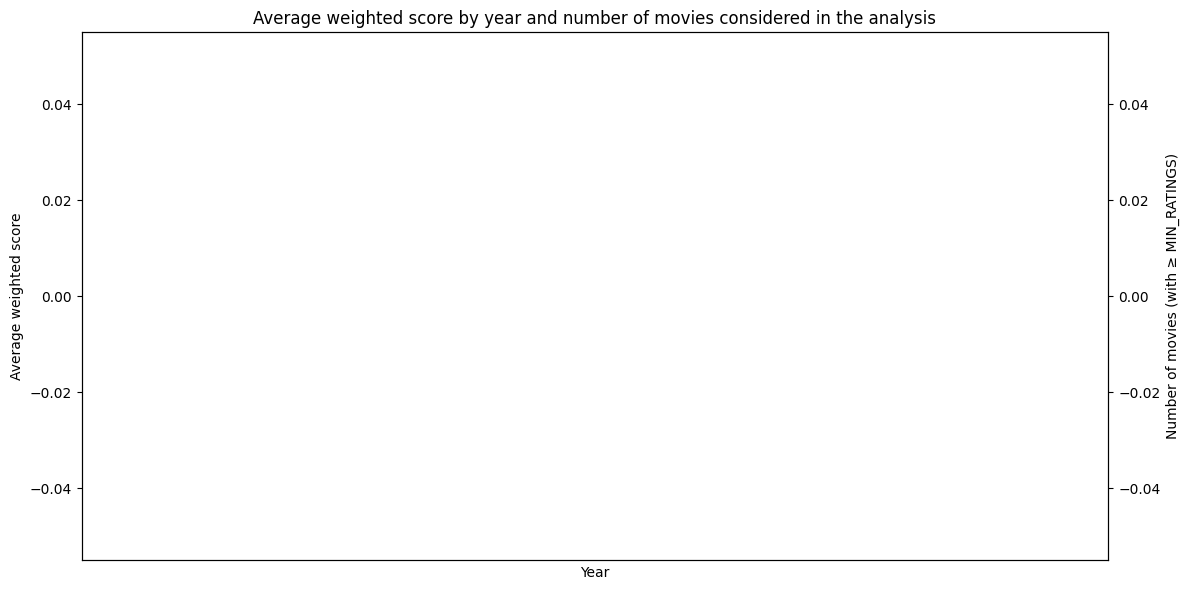

In [18]:
# Yearly Weighted Movie Scores 
# Years with at least 100 Films per Year and movies with at least 50 ratings
fig, ax1 = plt.subplots(figsize=(12, 6))

years = df_year["year"]
scores = df_year["avg_weighted_score"]
counts = df_year["n_movies"]

# --- Criar labels com apenas os últimos 2 dígitos ---
year_labels = years.astype(str).apply(lambda x: "'" + x[-2:])

# 1) Linha do score (eixo esquerdo)
ax1.plot(years, scores, marker="o")
ax1.set_xlabel("Year")
ax1.set_ylabel("Average weighted score")
ax1.tick_params(axis="y")

# Mostrar valores nos pontos
for x, y in zip(years, scores):
    ax1.text(x, y, f"{y:.2f}", fontsize=8, ha="center", va="bottom")

# 2) Barras do nº de filmes (eixo direito)
ax2 = ax1.twinx()
ax2.bar(years, counts, alpha=0.3)
ax2.set_ylabel("Number of movies (with ≥ MIN_RATINGS)")
ax2.tick_params(axis="y")

# --- Aplicar as labels reduzidas no eixo X ---
plt.xticks(years, year_labels, rotation=45)

plt.title("Average weighted score by year and number of movies considered in the analysis")
plt.tight_layout()
plt.show()


##### 2.9.2 Weighted Movie Scores Grouped by decades
Years with at least 100 Films per Year and movies with at least 50 ratings

In [19]:
# Movies — Weighted score aggregated by decade (≥ MIN_RATINGS per movie, ≥ 100 movies per decade)

df_decade = con.sql(f"""
WITH movie_stats AS (
    SELECT
        m.movieId,
        m.title,
        AVG(r.rating) AS avg_rating,
        COUNT(*) AS total_ratings
    FROM ratings r
    JOIN movies m USING (movieId)
    GROUP BY m.movieId, m.title
    HAVING COUNT(*) >= {MIN_RATINGS}
),
with_minmax AS (
    SELECT
        *,
        MIN(total_ratings) OVER () AS min_ratings,
        MAX(total_ratings) OVER () AS max_ratings
    FROM movie_stats
),
scored_with_year_str AS (
    SELECT
        movieId,
        title,
        ROUND(avg_rating, 2) AS avg_rating,
        total_ratings,
        CASE
            WHEN max_ratings = min_ratings THEN 3.0
            ELSE 1.0 + 4.0 * (total_ratings - min_ratings) / (max_ratings - min_ratings)
        END AS scaled_count_1_5,
        regexp_extract(title, '.*\\((\\d{{4}})\\)$', 1) AS year_str
    FROM with_minmax
),
scored AS (
    SELECT
        movieId,
        title,
        avg_rating,
        total_ratings,
        scaled_count_1_5,
        CAST(year_str AS INTEGER) AS year
    FROM scored_with_year_str
    WHERE year_str IS NOT NULL AND year_str <> ''
),
with_scores AS (
    SELECT
        year,
        (0.5 * avg_rating + 0.5 * scaled_count_1_5) AS weighted_score
    FROM scored
)
SELECT
    CAST(FLOOR(year / 10) * 10 AS INTEGER) AS decade,
    ROUND(AVG(weighted_score), 3) AS avg_score_decade,
    COUNT(*) AS movies_in_decade
FROM with_scores
GROUP BY decade
HAVING COUNT(*) >= 100          
ORDER BY decade;
""").df()

df_decade


,decade,avg_score_decade,movies_in_decade
0,1990,2.638,193
1,2000,2.576,136


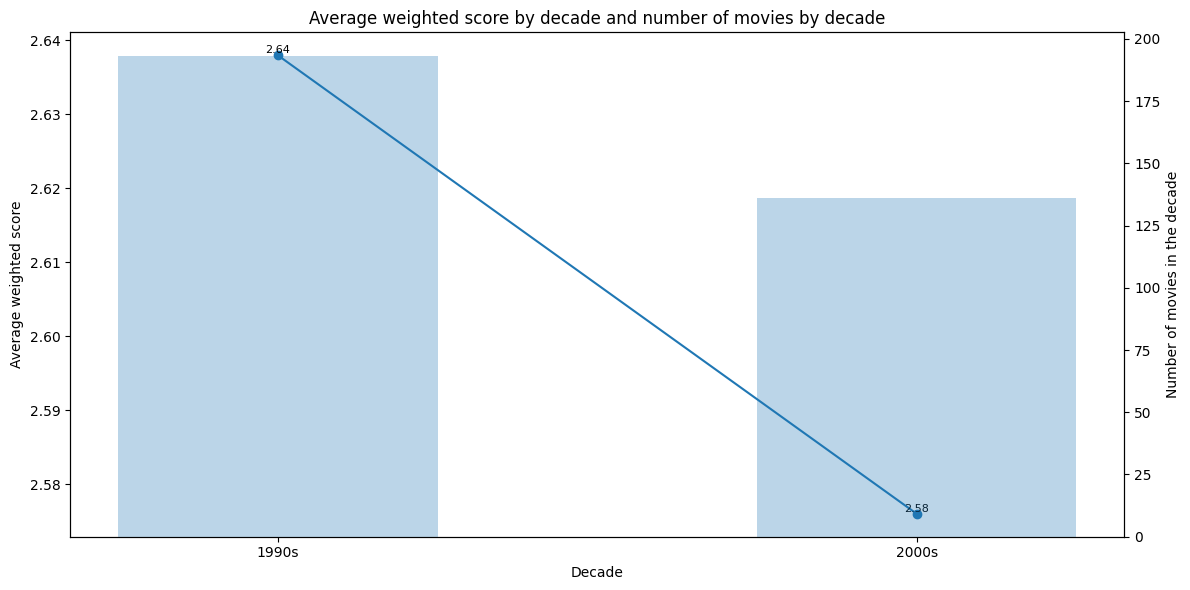

In [20]:
# Decade vs Average Weighted Score and number of movies
decades = df_decade["decade"].astype(int)
scores = df_decade["avg_score_decade"]
counts = df_decade["movies_in_decade"]

# labels bonitos: 1980s, 1990s, ...
decade_labels = decades.astype(str) + "s"

fig, ax1 = plt.subplots(figsize=(12, 6))

# 1) Linha com o rating médio por década (eixo da esquerda)
ax1.plot(decades, scores, marker="o")
ax1.set_xlabel("Decade")
ax1.set_ylabel("Average weighted score")
ax1.tick_params(axis="y")

# valores em cima dos pontos
for x, y, label in zip(decades, scores, decade_labels):
    ax1.text(x, y, f"{y:.2f}", fontsize=8, ha="center", va="bottom")

# 2) Barras com nº de filmes na década (eixo da direita)
ax2 = ax1.twinx()
ax2.bar(decades, counts, width=5, alpha=0.3)
ax2.set_ylabel("Number of movies in the decade")
ax2.tick_params(axis="y")


# usar labels '1980s', '1990s' no eixo X
plt.xticks(decades, decade_labels, rotation=45)

plt.title("Average weighted score by decade and number of movies by decade")
plt.tight_layout()
plt.show()


#### 2.10Most common tags and corresponding average score

In [21]:
df_tags = con.sql(f"""
SELECT
    word,
    COUNT(*) AS total,
    ROUND(AVG(r.rating), 3) AS avg_rating
FROM (
    SELECT
        t.movieid,
        LOWER(TRIM(w)) AS word
    FROM tags t
    CROSS JOIN UNNEST(split(t.tag, ' ')) AS u(w)
) words
JOIN ratings r
    ON r.movieid = words.movieid
WHERE word <> ''
  AND LENGTH(word) > 2
  AND word NOT IN ('the', 'and', 'for', 'with', 'this', 'that', 'are')
GROUP BY word
ORDER BY total DESC
LIMIT 30
""").df()

df_tags

,word,total,avg_rating
0,comedy,4572,3.975
1,space,3611,4.034
2,dark,3529,4.087
3,sci-fi,3508,4.074
4,classic,3143,4.132
5,ending,3080,4.041
6,great,2829,4.110
7,twist,2822,4.083
8,violence,2699,4.178
9,soundtrack,2638,4.082


The previous query took 14 m as 12s to complete!

#### Fechar a ligação

In [22]:
con.close()
print("Ligação fechada.")

Ligação fechada.
